In [38]:
#Importa librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import pickle  



DATA COLLECTION

1. Datos de Yahoo Finance

In [39]:
sp500 = yf.Ticker("^GSPC")
gold = yf.Ticker("^GC=F")
oil= yf.Ticker("CL=F")
brent= yf.Ticker("BZ=F")

Gold no existe. El ticker no baja ninguna información. Lo sustituyo por la volatilidad del mercado de oro que se descarga de los datos de la FED de St. Louis.

Para el Sp500 utilizo los datos a partir del año 2000, ya que en años anteriores la composición por industria del SP500 era bastante diferente. A partir de ese año hay importnate participación del sector teconología. Hago lo mismo para las otras variables

In [40]:
start_date = '2000-01-01'
end_date = '2024-04-30'

sp500 = sp500.history(period="max")
sp500 =sp500.loc[start_date:end_date].copy ()
oil = oil.history(period="max")
oil = oil.loc[start_date:end_date].copy ()
brent = brent.history(period="max") 
brent = brent.loc[start_date:end_date:].copy ()


In [41]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0


In [42]:
#Remueve las columans que no necesito
sp500 = sp500.drop(columns=['Dividends', 'Stock Splits'])
sp500.index= sp500.index.tz_localize(None) # remove timezone porque tengo otras variables que no la tienen. para uniformar

In [43]:
#Guarda el dataset en un archivo csv   
sp500.to_csv('sp500.csv', index=True)

In [44]:
#Hace lo mismo con el resto de los activos
oil = oil.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'])
oil.index= oil.index.tz_localize(None) # remove timezone
oil.head()

,Close
Date,
2000-08-23,32.049999
2000-08-24,31.629999
2000-08-25,32.049999
2000-08-28,32.869999
2000-08-29,32.720001


In [45]:
# Renombr< la columna 'Close' a 'Close_oil' en el DataFrame 'oil' para que no se confunda con la del S&P 500
oil.rename(columns={'Close': 'Close_oil'}, inplace=True)

# Muestra las primeras filas para verificar el cambio
print(oil.head())


            Close_oil
Date                 
2000-08-23  32.049999
2000-08-24  31.629999
2000-08-25  32.049999
2000-08-28  32.869999
2000-08-29  32.720001


2. Datos de FRED (Banco de la Reserva Federal de St. Louis) -

Información económica diaria y que refleja expectativas del mercado. Como no existen variables fundamentales diarias relacionadas con el índice, 
incluyo variables diarias del mercado que reflejen el sentimiento de la evolución de la economía, lo cual afecta consecuentemente la evolución de las empresas y su valor.
Las variables macro y las fundamentales en general no suelen ser diarias.

In [46]:
import requests


# FRED API endpoint
url = "https://api.stlouisfed.org/fred/series/observations"

# List of series IDs to be downloaded
# CREDIT RISK AND RISK APPETITE VARIABLES # OJO --->>>> Estas variables miden el riesgo de crédito y el apetito por el riesgo de los inversores 

# DAAA = Moody's Seasoned Aaa Corporate Bond Yield
# AAA10Y = Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# DBAA = Moody's Seasoned Baa Corporate Bond Yield
# BAA10Y = Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# BAMLH0A0HYM2 = ICE BofA US High Yield Index Option-Adjusted Spread 
# BAMLH0A2HYB = ICE BofA Single-B US High Yield Index Option-Adjusted Spread 
# BAMLH0A3HYC = ICE BofA CCC & Lower US High Yield Index Option-Adjusted Spread
# BAMLHE00EHYIOAS = ICE BofA Euro High Yield Index Option-Adjusted Spread -  

# INTEREST RATE VARIABLES
#OJO --->>>> Esta variables miden el cambio en las expectativas de inflación y los movimientos de tasas de interés

# T10Y2Y = 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
# T10Y3M = 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity  
# T5YIE = 5-Year Breakeven Inflation Rate (Expected Inflation Rate) - 5-Year 

# EXCHANGE RATES Vs main commercial partners for the U.S.
# DEXUSEU = U.S. Dollars to Euro Spot Exchange Rate - value of one U.S. Dollar in Euros
# DEXCHUS = Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate - value of one Chinese Yuan Renminbi in U.S. Dollars
# DEXCAUS = Canadian Dollars to U.S. Dollar Spot Exchange Rate - value of one Canadian Dollar in U.S. Dollars
# DEXMXUS= Mexican Pesos to U.S. Dollar Spot Exchange Rate - value of one Mexican Peso in U.S. Dollars

# VOLATILITY INDECES (MARKET EXPECTATION OF NEAR TERM VOLATILITY)
# VIXCLS = CBOE Volatility Index - VIX measures market expectation of near term volatility conveyed by stock index option prices.
#(GVZCLS)= CBOE Gold ETF Volatility Index 

series_ids = ['DAAA','AAA10Y','DBAA','BAA10Y','BAMLH0A0HYM2','BAMLH0A2HYB','BAMLH0A3HYC','BAMLHE00EHYIOAS','T10Y2Y','T10Y3M','T5YIE','DEXUSEU','DEXCHUS','DEXCAUS','DEXMXUS','VIXCLS','GVZCLS']

# Your FRED API key
api_key = '7de04d83472c6affd4e0a1505211d3b9'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each series ID
for series_id in series_ids:
    # API parameters
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response to JSON
        data = response.json()
        # Extract data for DataFrame
        dates = [item['date'] for item in data['observations']]
        values = [item['value'] for item in data['observations']]
        # Create DataFrame and convert types
        temp_df = pd.DataFrame({'Date': dates, series_id: values})
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        temp_df[series_id] = pd.to_numeric(temp_df[series_id], errors='coerce')
        # Add the DataFrame to the dictionary
        dfs[series_id] = temp_df.set_index('Date')
    else:
        print(f"Failed to retrieve data for {series_id}: {response.status_code}")

# Combine all the series DataFrames into one DataFrame 
macroeconomic_df = pd.concat(dfs.values(), axis=1)




3. Uno los dataframes

In [47]:
# Unir macroeconomic_df con sp500 basado en sus índices de fecha
AllVar_df =sp500.join(macroeconomic_df, how='inner')

print(AllVar_df.index)
AllVar_df = AllVar_df.sort_index()

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22',
               '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
               '2024-04-29', '2024-04-30'],
              dtype='datetime64[ns]', name='Date', length=6120, freq=None)


In [48]:
# Unir el DataFrame 'oil' al 'AllVar_df' que ya contiene datos combinados de 'macroeconomic_df' y 'sp500'
# Asegúrate de que 'oil' está indexado adecuadamente, si es necesario
if 'Date' in oil.columns:
    oil.set_index('Date', inplace=True)

# Especificando sufijos para resolver el conflicto de nombres de columnas
AllVar_df = AllVar_df.join(oil, how='inner', lsuffix='_AllVar', rsuffix='_oil')

# Mostrar las primeras filas para verificar las nuevas columnas
print(AllVar_df.head())

                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  T10Y2Y  T10Y3M  \
Date                                                  ...                   
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   -0.47   -0.56   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   -0.46   -0.56   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   -0.46   -0.58   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   -0.45   -0.54  

4. Calculo metricas de cambios

4.2 Calculo de las variables para análisis técnico (variables calculadas a partir de los precios de los activos). Ayudan a la toma de decisiones al dar información sobre el comportamiento de cada activo a través del tiempo.
Buscan determinar tendencias en los precios.

Medias moviles (dias h'abiles)

In [49]:
#Calculo la media 
# Periodos para las medias móviles
moving_avg_periods = [5,10, 20,200]

# Calcular y asignar cada media móvil utilizando un bucle
for period in moving_avg_periods:
    AllVar_df[f'{period}d_moving_avg'] = AllVar_df['Close'].rolling(window=period).mean()

# Mostrar las primeras filas para verificar las nuevas columnas
AllVar_df.head()



,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,DEXCHUS,DEXCAUS,DEXMXUS,VIXCLS,GVZCLS,Close_oil,5d_moving_avg,10d_moving_avg,20d_moving_avg,200d_moving_avg
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,8.2793,1.4877,9.2725,17.38,NaN,32.049999,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,8.2799,1.4871,9.2440,17.04,NaN,31.629999,NaN,NaN,NaN,NaN
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,8.2799,1.4828,9.2320,16.53,NaN,32.049999,NaN,NaN,NaN,NaN
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,8.2799,1.4845,9.2130,16.54,NaN,32.869999,NaN,NaN,NaN,NaN
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,8.2799,1.4868,9.2325,16.89,NaN,32.720001,1508.931982,NaN,NaN,NaN


Media movil ultimos 10 días hábiles

In [50]:
#Calculo el promedio móvil ponderado de los ultimas 2 semanas

# Definimos los pesos decrecientes para los últimos 10 días hábiles.
weights = np.arange(1, 11)[::-1]  # Esto crea un array de numpy: [10, 9, ..., 2, 1]

# Calculamos el WMA para cada ventana de 10 días hábiles.
# Usamos apply para aplicar una función personalizada que calcula el WMA de manera vectorizada.
AllVar_df['10d_wma'] = AllVar_df['Close'].rolling(window=10).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Ahora, el DataFrame 'AllVar_df' contiene una nueva columna '10d_wma' con el WMA de 10 días.
# Muestra los primeros registros para verificar.
print(AllVar_df[['Close', '10d_wma']].head(20))


                  Close      10d_wma
Date                                
2000-08-23  1505.969971          NaN
2000-08-24  1508.310059          NaN
2000-08-25  1506.449951          NaN
2000-08-28  1514.089966          NaN
2000-08-29  1509.839966          NaN
2000-08-30  1502.589966          NaN
2000-08-31  1517.680054          NaN
2000-09-01  1520.770020          NaN
2000-09-05  1507.079956          NaN
2000-09-06  1492.250000  1509.020898
2000-09-07  1502.510010  1509.418539
2000-09-08  1494.500000  1509.139617
2000-09-11  1489.260010  1508.886353
2000-09-12  1481.989990  1506.660358
2000-09-13  1484.910034  1504.753820
2000-09-14  1480.869995  1503.770554
2000-09-15  1465.810059  1499.100546
2000-09-18  1444.510010  1492.482180
2000-09-19  1459.900024  1487.495099
2000-09-20  1451.339966  1484.460556


Momentum

In [51]:
# Calcular el momentum como el cambio día a día en la columna 'Close'. Es lo mismo que el daily change pero en absoluto no porcentual
AllVar_df['Momentum'] = AllVar_df['Close'].diff()

print(AllVar_df.head())  # Mostrar las primeras filas para verificar la nueva columna

                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  DEXMXUS  VIXCLS  \
Date                                                  ...                    
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   9.2725   17.38   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   9.2440   17.04   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   9.2320   16.53   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   9.2130   1

Stochastic %K

El Stochastic %K es una medida de la posición relativa del precio de cierre actual en relación con el rango alto-bajo durante un número específico de períodos pasados. La fórmula para calcular el Stochastic %K es la siguiente:

% K = [(C-LLn)/(HHn-LLn)]x 100� 

donde:


C es el precio de cierre más reciente,

LLn es el precio más bajo de los prcios bajos (Low) en los últimos n períodos,
Hn  es el precio más alto de lso pecios altos (High) en los últimos n períodos,
n es el número de períodos utilizados para el cálculo.
El valor de n varía según el análisis, pero los valores comunes incluyen 14, 20 o cualquier otro valor dependiendo de la estrategia de trading

In [52]:
# Calcular el Stochastic %K para cada fila basado en los 20 días laborables previos
# Crear una función para encapsular el cálculo
#def calculate_stochastic_k(row_index, df):
    #if row_index < 19:  # Asegurar que haya suficientes datos para los primeros 19 registros
        #return None
    #else:
        #period = df['Close'][row_index-19:row_index+1]  # Seleccionar los últimos 20 registros hasta el índice actual
        #low_20 = period.min()
        #high_20 = period.max()
        #close_recent = df['Close'].iloc[row_index]
        #stochastic_k = ((close_recent - low_20) / (high_20 - low_20)) * 100
        #return stochastic_k

# Aplicar la función a cada fila
# Nota: Esto puede ser lento para DataFrames muy grandes debido al enfoque iterativo
#sp500['Stochastic_%K'] = [calculate_stochastic_k(i, sp500) for i in range(len(sp500))]

#print(sp500.tail())  # Mostrar las últimas filas para verificar la nueva columna
#sp500.head


# Crea una función para encapsular el cálculo del Stochastic %K
def calculate_stochastic_k(row_index, df):
    if row_index < 19:  # Asegurar que haya suficientes datos para los primeros 19 registros
        return None
    else:
        # Seleccionar los últimos 20 registros hasta el índice actual para las columnas 'High' y 'Low'
        high_period = df['High'][row_index-19:row_index+1]
        low_period = df['Low'][row_index-19:row_index+1]
        low_20 = low_period.min()
        high_20 = high_period.max()
        close_recent = df['Close'].iloc[row_index]
        
        # Calcular el Stochastic %K
        stochastic_k = ((close_recent - low_20) / (high_20 - low_20)) * 100
        return stochastic_k

# Aplica la función a cada fila
AllVar_df['Stochastic_%K'] = [calculate_stochastic_k(i, AllVar_df) for i in range(len(AllVar_df))]

# Muestra las últimas filas para verificar la nueva columna
print(AllVar_df.tail())


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  VIXCLS  GVZCLS  \
Date                                                  ...                   
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...   15.97   17.45   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...   15.37   17.32   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...   15.03   16.92   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...   14.67   

Stochastic %D

El indicador Stochastic %D es una media móvil del indicador Stochastic %K. Usualmente se calcula como la media móvil simple de los últimos 3 valores de %K. Para calcular el %D para las últimas 20 observaciones de tu DataFrame sp500, primero necesitaríamos calcular el %K como se discutió anteriormente, y luego aplicar una media móvil sobre esos valores de %K.

In [53]:

# Calcular el Stochastic %D como la media móvil simple de 3 días de %K
AllVar_df['Stochastic_%D'] = AllVar_df['Stochastic_%K'].rolling(window=3).mean()

# Si solo necesitas las últimas 20 observaciones para el %D, puedes hacer lo siguiente:
last_20_stochastic_D = AllVar_df['Stochastic_%D'][-20:]

print(last_20_stochastic_D)
AllVar_df.head(9)

Date
2024-04-03    76.922842
2024-04-04    57.726515
2024-04-05    55.575326
2024-04-08    53.829101
2024-04-09    64.992990
2024-04-10    54.961573
2024-04-11    53.283501
2024-04-12    35.318808
2024-04-15    25.095684
2024-04-16     7.141325
2024-04-17     5.118661
2024-04-18     4.821237
2024-04-19     4.569616
2024-04-22     8.741723
2024-04-23    20.099123
2024-04-24    31.278398
2024-04-25    35.328193
2024-04-26    38.522920
2024-04-29    43.766969
2024-04-30    42.643557
Name: Stochastic_%D, dtype: float64


,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,GVZCLS,Close_oil,5d_moving_avg,10d_moving_avg,20d_moving_avg,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,32.049999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,NaN,31.629999,NaN,NaN,NaN,NaN,NaN,2.340088,NaN,NaN
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,NaN,32.049999,NaN,NaN,NaN,NaN,NaN,-1.860107,NaN,NaN
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,NaN,32.869999,NaN,NaN,NaN,NaN,NaN,7.640015,NaN,NaN
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,NaN,32.720001,1508.931982,NaN,NaN,NaN,NaN,-4.250000,NaN,NaN
2000-08-30,1509.839966,1510.489990,1500.089966,1502.589966,818400000,7.58,1.77,8.30,2.49,6.28,...,NaN,33.400002,1508.255981,NaN,NaN,NaN,NaN,-7.250000,NaN,NaN
2000-08-31,1502.589966,1525.209961,1502.589966,1517.680054,1056600000,7.52,1.79,8.24,2.51,6.43,...,NaN,33.099998,1510.129980,NaN,NaN,NaN,NaN,15.090088,NaN,NaN
2000-09-01,1517.680054,1530.089966,1515.530029,1520.770020,767700000,7.51,1.83,8.22,2.54,6.48,...,NaN,33.380001,1512.993994,NaN,NaN,NaN,NaN,3.089966,NaN,NaN
2000-09-05,1520.770020,1520.770020,1504.209961,1507.079956,838500000,7.51,1.82,8.22,2.53,6.41,...,NaN,33.799999,1511.591992,NaN,NaN,NaN,NaN,-13.690063,NaN,NaN


El Índice de Fuerza Relativa

El Índice de Fuerza Relativa (RSI, por sus siglas en inglés) es un indicador de momento que mide la magnitud de los movimientos recientes de precios para evaluar condiciones de sobrecompra o sobreventa en el precio de un activo. Se calcula utilizando la fórmula:

RSI=100− 100/(1+RS)
 

donde 
�
�
RS es la relación media de días de cierre hacia arriba entre la media de días de cierre hacia abajo. Para calcularlo para los últimos 20 y 10 días, necesitamos seguir los siguientes pasos para cada ventana de tiempo:

Calcular los cambios diarios en el precio de cierre.
Separar estos cambios en ganancias (aumentos) y pérdidas (disminuciones).
Calcular el promedio de ganancias y el promedio de pérdidas sobre el período de interés (20 días y 10 días, respectivamente).
Calcular el RS, que es el promedio de ganancias dividido por el promedio de pérdidas.
Utilizar la fórmula del RSI para obtener el valor final.

In [54]:
# Separar las ganancias (positivas) de las pérdidas (negativas)
gain = AllVar_df['Momentum'].mask(AllVar_df['Momentum'] > 0, 0)
loss = -AllVar_df['Momentum'].mask(AllVar_df['Momentum'] < 0, 0)

# Calcular el RSI para los últimos 20 y 10 días
window_lengths = [20, 10]

for length in window_lengths:
    # Calcular el promedio de ganancias y pérdidas
    avg_gain = gain.rolling(window=length, min_periods=1).mean()
    avg_loss = loss.rolling(window=length, min_periods=1).mean()
    
    # Calcular RS
    rs = avg_gain / avg_loss
    
    # Calcular RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Adjuntar al DataFrame
    AllVar_df[f'RSI_{length}'] = rsi

# Mostrar las últimas 20 filas para verificar las nuevas columnas
print(AllVar_df.tail(20))



                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-03  5194.370117  5228.750000  5194.370117  5211.490234  3703250000   
2024-04-04  5244.049805  5256.589844  5146.060059  5147.209961  4075680000   
2024-04-05  5158.950195  5222.180176  5157.209961  5204.339844  3386780000   
2024-04-08  5211.370117  5219.569824  5197.350098  5202.390137  3278180000   
2024-04-09  5217.029785  5224.810059  5160.779785  5209.910156  3400680000   
2024-04-10  5167.879883  5178.430176  5138.700195  5160.640137  3845930000   
2024-04-11  5172.950195  5211.779785  5138.770020  5199.060059  3509380000   
2024-04-12  5171.509766  5175.029785  5107.939941  5123.410156  3963220000   
2024-04-15  5149.669922  5168.430176  5052.470215  5061.819824  3950210000   
2024-04-16  5064.589844  5079.839844  5039.830078  5051.410156  4006200000   
2024-04-17  5068.970215  5077.959961  5007.250000  5022.209961  

Indicador Larry Williams %R

El indicador Larry Williams %R es una medida de momentum que se utiliza para identificar niveles de sobrecompra y sobreventa en un mercado. Se calcula como un porcentaje que refleja la posición del precio de cierre relativo a su rango más alto y más bajo durante un número específico de períodos pasados. La fórmula del Larry Williams %R es:

%R= [(Hn-C)/(Hn-Ln)]x100

donde:

C es el precio de cierre actual,
Hn  es el precio más alto en los últimos n períodos,
Ln es el precio más bajo en los últimos 
�
n períodos,
�
n es el número de períodos utilizados para el cálculo.
Generalmente, se utiliza un período de 14 días para el cálculo de este indicador, pero se puede ajustar según las necesidades del análisis. Para agregar el Larry Williams %R al DataFrame sp500 para los últimos 14 días, puedes usar el siguiente código:

In [55]:
# Asumiendo que sp500 es tu DataFrame y tiene columnas 'High', 'Low', y 'Close' con los precios más altos, más bajos y de cierre

# Configurar el número de períodos para el cálculo de Williams %R
n = 10

# Calcular el precio más alto y el más bajo de los últimos n días
high_n = AllVar_df['High'].rolling(window=n).max()
low_n = AllVar_df['Low'].rolling(window=n).min()

# Calcular el Williams %R
AllVar_df['Williams_%R'] = ((high_n - AllVar_df['Close']) / (high_n - low_n)) * -100

# Mostrar las últimas filas para verificar la nueva columna
print(AllVar_df.tail())


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  10d_moving_avg  \
Date                                                  ...                   
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...     5058.904004   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...     5043.839990   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...     5041.494971   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...     5046.9

Moving Average Convergence/Divergence Oscillator

The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter one. As a result, the MACD offers the best of both worlds: trend following and momentum. The MACD fluctuates above and below the zero line as the moving averages converge, cross and diverge. Traders can look for signal line crossovers, centerline crossovers and divergences to generate signals. Because the MACD is unbounded, it is not particularly useful for identifying overbought and oversold levels.

In [56]:
#https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd


# Calcular las EMAs de 12 y 26 períodos para la columna 'Close'
ema12 = AllVar_df['Close'].ewm(span=12, adjust=False).mean()
ema26 = AllVar_df['Close'].ewm(span=26, adjust=False).mean()

# Calcular el MACD restando la EMA de 26 períodos de la EMA de 12 períodos
AllVar_df['MACD'] = ema12 - ema26

# Calcular la línea de señal como la EMA de 9 períodos del MACD
AllVar_df['Signal_Line'] = AllVar_df['MACD'].ewm(span=9, adjust=False).mean()

# Mostrar las últimas filas para verificar las nuevas columnas
print(AllVar_df.tail())
AllVar_df.head()


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  200d_moving_avg  \
Date                                                  ...                    
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...      4683.744802   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...      4686.790603   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...      4689.929602   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...      

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D,RSI_20,RSI_10,Williams_%R,MACD,Signal_Line
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,NaN,NaN,2.340088,NaN,NaN,0.000000,0.000000,NaN,0.186674,0.037335
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,NaN,NaN,-1.860107,NaN,NaN,44.286213,44.286213,NaN,0.182416,0.066351
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,NaN,NaN,7.640015,NaN,NaN,15.710088,15.710088,NaN,0.786461,0.210373
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,NaN,NaN,-4.250000,NaN,NaN,37.974069,37.974069,NaN,0.911722,0.350643


4.3 Cambios diarios
Trabajo con daily changes y no números absolutos porque ARIMA y modelos en general trabajan mejor con series estacionarias. Para observaciones diarias, los cambios diarios son una forma común de estacionarizar la serie temporal.

In [57]:
# Calcular los retornos diarios 
retornos_diarios = AllVar_df[['Close']].pct_change()

# Multiplicar por 100 para obtener porcentajes
retornos_diarios = retornos_diarios * 100

# Añadir la columna de retornos diarios al DataFrame original
# Nombrando la columna como 'Retornos Diarios'
AllVar_df['Daily Returns'] = retornos_diarios




In [58]:
columns_to_change = [
    'DAAA', 'AAA10Y', 'DBAA', 'BAA10Y', 'BAMLH0A0HYM2', 'BAMLH0A2HYB', 
    'BAMLH0A3HYC', 'BAMLHE00EHYIOAS', 'T10Y2Y', 'T10Y3M', 'T5YIE', 'DEXUSEU', 
    'DEXCHUS', 'DEXCAUS', 'DEXMXUS', 'VIXCLS', 'GVZCLS'
]
for column in columns_to_change:
    new_column_name = f'{column}_daily_change'
    AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100

print(AllVar_df.head())


                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  \
Date                                                  ...   
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   
2000-08-29  7.58    1.77  8.30    2.49          6.30  ...   

            BAMLHE00EHYIOAS_dail

C:\Users\lgarn\AppData\Local\Temp\ipykernel_12784\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100
C:\Users\lgarn\AppData\Local\Temp\ipykernel_12784\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100
C:\Users\lgarn\AppData\Local\Temp\ipykernel_12784\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to callin

In [59]:
# Calcula los cambios diarios en el precio del oil.
AllVar_df['oil_daily_changes'] = AllVar_df['Close_oil'].pct_change() * 100  # Multiplicar por 100 para convertir a porcentaje


In [60]:
AllVar_df.head()

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,T10Y2Y_daily_change,T10Y3M_daily_change,T5YIE_daily_change,DEXUSEU_daily_change,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,-2.127660,0.000000,NaN,0.680272,0.007247,-0.040331,-0.307360,-1.956272,NaN,-1.310453
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,0.000000,3.571429,NaN,-0.044307,0.000000,-0.289153,-0.129814,-2.992958,NaN,1.327854
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,-2.173913,-6.896552,NaN,-0.243794,0.000000,0.114648,-0.205806,0.060496,NaN,2.558501
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,0.000000,-7.407407,NaN,-0.399911,0.000000,0.154934,0.211657,2.116082,NaN,-0.456336


In [61]:
# Contar los valores nulos en cada columna
null_counts_All = AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna antes de limpiar:\n", null_counts_All)

# Reemplazar los valores infinitos por NaN
AllVar_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar las filas con valores nulos o NaN
AllVar_df = AllVar_df.dropna()

# Contar de nuevo los valores nulos en cada columna
null_counts_clean = AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna después de limpiar:\n", null_counts_clean)

# Guardar el DataFrame limpio a un archivo CSV
#AllVar_df.to_csv("AllVar_df_clean.csv", index=False)


Conteo de valores nulos por columna antes de limpiar:
 Open                               0
High                               0
Low                                0
Close                              0
Volume                             0
DAAA                              39
AAA10Y                            44
DBAA                              39
BAA10Y                            44
BAMLH0A0HYM2                       2
BAMLH0A2HYB                        2
BAMLH0A3HYC                        2
BAMLHE00EHYIOAS                    2
T10Y2Y                            42
T10Y3M                            42
T5YIE                            622
DEXUSEU                           53
DEXCHUS                           53
DEXCAUS                           53
DEXMXUS                           53
VIXCLS                             0
GVZCLS                          1940
Close_oil                          0
5d_moving_avg                      4
10d_moving_avg                     9
20d_moving_avg      

IMPORTANTE: cuando se unen todas las variables en AllVar_df, se cambia año de inicio al 2008 porque es cuando hay datos para todas.

In [62]:
AllVar_df.head()

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,T10Y2Y_daily_change,T10Y3M_daily_change,T5YIE_daily_change,DEXUSEU_daily_change,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-04,1376.260010,1388.180054,1371.739990,1377.199951,4338640000,5.64,1.66,7.02,3.04,6.79,...,2.721088,3.381643,-1.694915,-0.006471,0.421107,0.935230,0.291545,2.766798,-0.873744,-1.616921
2008-06-05,1377.479980,1404.050049,1377.479980,1404.050049,4350790000,5.69,1.63,7.07,3.01,6.63,...,1.986755,3.271028,2.155172,0.692422,-0.248445,0.492854,-0.077519,-10.432692,0.396651,4.488960
2008-06-06,1400.060059,1400.060059,1359.900024,1360.680054,4771660000,5.61,1.67,6.98,3.04,6.68,...,0.000000,-5.429864,3.375527,1.098972,-0.331126,-0.078470,0.543057,26.462695,3.599649,8.412233
2008-06-09,1360.829956,1370.630005,1350.619995,1361.760010,4404570000,5.58,1.56,6.96,2.94,6.58,...,-16.233766,1.913876,1.224490,-0.082639,0.000000,0.353392,-0.038580,-1.867572,3.686441,-3.024388
2008-06-10,1358.979980,1366.839966,1351.560059,1358.439941,4635070000,5.66,1.55,7.05,2.94,6.49,...,-6.976744,-1.877934,0.000000,-1.558722,0.026000,0.176074,0.231571,0.259516,3.759706,-2.262753


In [63]:
# Crear un "lag" de 1 día para los retornos diarios
AllVar_df['Lag 1_Returns'] = AllVar_df['Daily Returns'].shift(+1)
AllVar_df['Lag 2_Returns'] = AllVar_df['Daily Returns'].shift(+2)
AllVar_df['Next_Day_Returns'] = AllVar_df['Daily Returns'].shift(-1)

# Crear la columna 'TARGET' basada en 'Lagged_Daily_Returns' - Quiero predecir si el retorno del día siguiente será positivo o negativo basado con respecto al día actual en el que tomo la decision al final del día
AllVar_df['TARGET'] = np.where(AllVar_df['Next_Day_Returns'] > 0, 1, 0)

# Mostrar las primeras filas para verificar las nuevas columnas
AllVar_df.head()

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes,Lag 1_Returns,Lag 2_Returns,Next_Day_Returns,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-04,1376.260010,1388.180054,1371.739990,1377.199951,4338640000,5.64,1.66,7.02,3.04,6.79,...,0.421107,0.935230,0.291545,2.766798,-0.873744,-1.616921,NaN,NaN,1.949615,1
2008-06-05,1377.479980,1404.050049,1377.479980,1404.050049,4350790000,5.69,1.63,7.07,3.01,6.63,...,-0.248445,0.492854,-0.077519,-10.432692,0.396651,4.488960,-0.032670,NaN,-3.088921,0
2008-06-06,1400.060059,1400.060059,1359.900024,1360.680054,4771660000,5.61,1.67,6.98,3.04,6.68,...,-0.331126,-0.078470,0.543057,26.462695,3.599649,8.412233,1.949615,-0.032670,0.079369,1
2008-06-09,1360.829956,1370.630005,1350.619995,1361.760010,4404570000,5.58,1.56,6.96,2.94,6.58,...,0.000000,0.353392,-0.038580,-1.867572,3.686441,-3.024388,-3.088921,1.949615,-0.243807,0
2008-06-10,1358.979980,1366.839966,1351.560059,1358.439941,4635070000,5.66,1.55,7.05,2.94,6.49,...,0.026000,0.176074,0.231571,0.259516,3.759706,-2.262753,0.079369,-3.088921,-1.689434,0


### IMPLEMENTACION PROPHET

Selecciono el tamaño del periodo de prueba y la fecha de inicio de análisis para el que el periodo de prueba se mantenga como una serie de tiempo en orden histórico.

In [64]:
fecha_inicio = '2014-04-30'
test_size_Control=0.2

In [65]:
# Convertir a datetime
fecha_inicio_1 = pd.to_datetime(fecha_inicio)
end_date_1 = pd.to_datetime(end_date)


# Calcular el total de días
total_dias = (end_date_1 - fecha_inicio_1).days

# Calcular el número de días para el entrenamiento
dias_entrenamiento = int(total_dias * (1 - test_size_Control))

# Calcular la fecha de corte
fecha_corte = fecha_inicio_1 + pd.Timedelta(days=dias_entrenamiento)

print("Fecha de corte para dividir los datos:", fecha_corte)
print("incio:", fecha_inicio)


Fecha de corte para dividir los datos: 2022-04-30 00:00:00
incio: 2014-04-30


In [66]:
from prophet import Prophet

In [67]:
# Seleccionamos los datos a partir de la fecha específica
SP500_Prophet = AllVar_df.loc[fecha_inicio:, 'Close']


In [68]:

SP500_Prophet = SP500_Prophet.reset_index()
SP500_Prophet = SP500_Prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

In [69]:
SP500_Prophet.head()

,ds,y
0,2014-04-30,1883.949951
1,2014-05-01,1883.680054
2,2014-05-02,1881.140015
3,2014-05-05,1884.660034
4,2014-05-06,1867.719971


In [70]:
# Dividir los datos en conjuntos de entrenamiento y prueba
cutoff_prophet = int(len(SP500_Prophet) * (1-test_size_Control))
train_prophet = SP500_Prophet.iloc[:cutoff_prophet]
test_prophet = SP500_Prophet.iloc[cutoff_prophet:]



In [71]:
train_prophet.head()

,ds,y
0,2014-04-30,1883.949951
1,2014-05-01,1883.680054
2,2014-05-02,1881.140015
3,2014-05-05,1884.660034
4,2014-05-06,1867.719971


In [72]:
test_prophet.head()

,ds,y
1984,2022-05-02,4155.379883
1985,2022-05-03,4175.479980
1986,2022-05-04,4300.169922
1987,2022-05-05,4146.870117
1988,2022-05-06,4123.339844


In [73]:
# Asumiendo que 'train_prophet' y 'test_prophet' son tus DataFrames que contienen la columna 'ds'

# Obtener el primer y último día del conjunto de entrenamiento
train_start = train_prophet['ds'].min()
train_end = train_prophet['ds'].max()

# Obtener el primer y último día del conjunto de prueba
test_start = test_prophet['ds'].min()
test_end = test_prophet['ds'].max()

print(f"Train Period: Start - {train_start}, End - {train_end}")
print(f"Test Period: Start - {test_start}, End - {test_end}")


Train Period: Start - 2014-04-30 00:00:00, End - 2022-04-29 00:00:00
Test Period: Start - 2022-05-02 00:00:00, End - 2024-04-30 00:00:00


In [74]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd

# Supongamos que train_prophet es tu DataFrame preparado
# train_prophet = pd.read_csv('tu_data.csv')  # Asegúrate de que 'ds' y 'y' están correctamente formateados

# Definición de los parámetros para explorar
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [10, 15, 20],
    'n_changepoints': [25, 50, 100]
}

# Preparación para guardar resultados de cada configuración
results = []

# Iterar sobre todas las combinaciones posibles de los hiperparámetros
for cps in param_grid['changepoint_prior_scale']:
    for sps in param_grid['seasonality_prior_scale']:
        for ncp in param_grid['n_changepoints']:
            model = Prophet(
                daily_seasonality=False,
                yearly_seasonality=True,
                weekly_seasonality=True,
                seasonality_prior_scale=sps,
                changepoint_prior_scale=cps,
                n_changepoints=ncp
            )
            model.fit(train_prophet)
            df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
            df_p = performance_metrics(df_cv)
            avg_rmse = df_p['rmse'].mean()

            # Guardar los resultados junto con los parámetros usados
            results.append({
                'changepoint_prior_scale': cps,
                'seasonality_prior_scale': sps,
                'n_changepoints': ncp,
                'rmse': avg_rmse
            })

# Encontrar la configuración de parámetros con el menor RMSE
best_params = min(results, key=lambda x: x['rmse'])
print("Mejores parámetros:", best_params)


23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/11 [00:00<?, ?it/s]

23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:18 - cmdstanpy - INFO - Chain [1] start processing
23:17:18 - cmdstanpy - INFO - Chain [1] done processing
23:17:18 - cmdstanpy - INFO - Chain [1] start processing
23:17:18 - cmdstanpy - INFO - Chain [1] done processing
23:17:18 - cmdstanpy - INFO - Chain [1] start processing
23:17:18 - cmdstanpy - INFO - Chain [1] done processing
23:17:18 - cmdstanpy - INFO - Chain [1] start processing
23:17:18 - cmdstanpy - INFO - Chain [1] done processing
23:17:19 - cmdstanpy - INFO - Chain [1] start processing
23:17:19 - cmdstanpy - INFO - Chain [1] done processing
23:17:19 - cmdstanpy - INFO - Chain [1] start processing
23:17:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:21 - cmdstanpy - INFO - Chain [1] start processing
23:17:21 - cmdstanpy - INFO - Chain [1] done processing
23:17:21 - cmdstanpy - INFO - Chain [1] start processing
23:17:21 - cmdstanpy - INFO - Chain [1] done processing
23:17:21 - cmdstanpy - INFO - Chain [1] start processing
23:17:21 - cmdstanpy - INFO - Chain [1] done processing
23:17:21 - cmdstanpy - INFO - Chain [1] start processing
23:17:21 - cmdstanpy - INFO - Chain [1] done processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] done processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] done processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:17:23 - cmdstanpy - INFO - Chain [1] start processing
23:17:24 - cmdstanpy - INFO - Chain [1] done processing
23:17:24 - cmdstanpy - INFO - Chain [1] start processing
23:17:24 - cmdstanpy - INFO - Chain [1] done processing
23:17:24 - cmdstanpy - INFO - Chain [1] start processing
23:17:24 - cmdstanpy - INFO - Chain [1] done processing
23:17:24 - cmdstanpy - INFO - Chain [1] start processing
23:17:24 - cmdstanpy - INFO - Chain [1] done processing
23:17:24 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:26 - cmdstanpy - INFO - Chain [1] start processing
23:17:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:17:27 - cmdstanpy - INFO - Chain [1] start processing
23:17:27 - cmdstanpy - INFO - Chain [1] done processing
23:17:27 - cmdstanpy - INFO - Chain [1] start processing
23:17:27 - cmdstanpy - INFO - Chain [1] done processing
23:17:27 - cmdstanpy - INFO - Chain [1] start processing
23:17:27 - cmdstanpy - INFO - Chain [1] done processing
23:17:27 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:29 - cmdstanpy - INFO - Chain [1] done processing
23:17:29 - cmdstanpy - INFO - Chain [1] start processing
23:17:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:17:30 - cmdstanpy - INFO - Chain [1] start processing
23:17:30 - cmdstanpy - INFO - Chain [1] done processing
23:17:30 - cmdstanpy - INFO - Chain [1] start processing
23:17:30 - cmdstanpy - INFO - Chain [1] done processing
23:17:30 - cmdstanpy - INFO - Chain [1] start processing
23:17:30 - cmdstanpy - INFO - Chain [1] done processing
23:17:30 - cmdstanpy - INFO - Chain [1] start processing
23:17:30 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:32 - cmdstanpy - INFO - Chain [1] start processing
23:17:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing
23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing
23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing
23:17:34 - cmdstanpy - INFO - Chain [1] start processing
23:17:34 - cmdstanpy - INFO - Chain [1] done processing
23:17:34 - cmdstanpy - INFO - Chain [1] start processing
23:17:34 - cmdstanpy - INFO - Chain [1] done processing
23:17:34 - cmdstanpy - INFO - Chain [1] start processing
23:17:34 - cmdstanpy - INFO - Chain [1] done processing
23:17:34 - cmdstanpy - INFO - Chain [1] start processing
23:17:35 - cmdstanpy - INFO - Chain [1] done processing
23:17:35 - cmdstanpy - INFO - Chain [1] start processing
23:17:35 - cmdstanpy - INFO - Chain [1] done processing
23:17:35 - cmdstanpy - INFO - Chain [1] start processing
23:17:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing
23:17:37 - cmdstanpy - INFO - Chain [1] start processing
23:17:37 - cmdstanpy - INFO - Chain [1] done processing
23:17:37 - cmdstanpy - INFO - Chain [1] start processing
23:17:37 - cmdstanpy - INFO - Chain [1] done processing
23:17:37 - cmdstanpy - INFO - Chain [1] start processing
23:17:37 - cmdstanpy - INFO - Chain [1] done processing
23:17:37 - cmdstanpy - INFO - Chain [1] start processing
23:17:37 - cmdstanpy - INFO - Chain [1] done processing
23:17:37 - cmdstanpy - INFO - Chain [1] start processing
23:17:37 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:40 - cmdstanpy - INFO - Chain [1] start processing
23:17:40 - cmdstanpy - INFO - Chain [1] done processing
23:17:40 - cmdstanpy - INFO - Chain [1] start processing
23:17:40 - cmdstanpy - INFO - Chain [1] done processing
23:17:40 - cmdstanpy - INFO - Chain [1] start processing
23:17:40 - cmdstanpy - INFO - Chain [1] done processing
23:17:40 - cmdstanpy - INFO - Chain [1] start processing
23:17:40 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:17:43 - cmdstanpy - INFO - Chain [1] start processing
23:17:43 - cmdstanpy - INFO - Chain [1] done processing
23:17:43 - cmdstanpy - INFO - Chain [1] start processing
23:17:43 - cmdstanpy - INFO - Chain [1] done processing
23:17:43 - cmdstanpy - INFO - Chain [1] start processing
23:17:43 - cmdstanpy - INFO - Chain [1] done processing
23:17:43 - cmdstanpy - INFO - Chain [1] start processing
23:17:43 - cmdstanpy - INFO - Chain [1] done processing
23:17:43 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:45 - cmdstanpy - INFO - Chain [1] done processing
23:17:45 - cmdstanpy - INFO - Chain [1] start processing
23:17:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:48 - cmdstanpy - INFO - Chain [1] start processing
23:17:48 - cmdstanpy - INFO - Chain [1] done processing
23:17:48 - cmdstanpy - INFO - Chain [1] start processing
23:17:48 - cmdstanpy - INFO - Chain [1] done processing
23:17:48 - cmdstanpy - INFO - Chain [1] start processing
23:17:49 - cmdstanpy - INFO - Chain [1] done processing
23:17:49 - cmdstanpy - INFO - Chain [1] start processing
23:17:49 - cmdstanpy - INFO - Chain [1] done processing
23:17:50 - cmdstanpy - INFO - Chain [1] start processing
23:17:50 - cmdstanpy - INFO - Chain [1] done processing
23:17:50 - cmdstanpy - INFO - Chain [1] start processing
23:17:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:17:53 - cmdstanpy - INFO - Chain [1] start processing
23:17:53 - cmdstanpy - INFO - Chain [1] done processing
23:17:53 - cmdstanpy - INFO - Chain [1] start processing
23:17:53 - cmdstanpy - INFO - Chain [1] done processing
23:17:54 - cmdstanpy - INFO - Chain [1] start processing
23:17:54 - cmdstanpy - INFO - Chain [1] done processing
23:17:54 - cmdstanpy - INFO - Chain [1] start processing
23:17:55 - cmdstanpy - INFO - Chain [1] done processing
23:17:55 - cmdstanpy - INFO - Chain [1] start processing
23:17:55 - cmdstanpy - INFO - Chain [1] done processing
23:17:56 - cmdstanpy - INFO - Chain [1] start processing
23:17:56 - cmdstanpy - INFO - Chain [1] done processing
23:17:56 - cmdstanpy - INFO - Chain [1] start processing
23:17:57 - cmdstanpy - INFO - Chain [1] done processing
23:17:58 - cmdstanpy - INFO - Chain [1] start processing
23:17:59 - cmdstanpy - INFO - Chain [1] done processing
23:17:59 - cmdstanpy - INFO - Chain [1] start processing
23:17:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:18:04 - cmdstanpy - INFO - Chain [1] start processing
23:18:05 - cmdstanpy - INFO - Chain [1] done processing
23:18:05 - cmdstanpy - INFO - Chain [1] start processing
23:18:05 - cmdstanpy - INFO - Chain [1] done processing
23:18:05 - cmdstanpy - INFO - Chain [1] start processing
23:18:06 - cmdstanpy - INFO - Chain [1] done processing
23:18:06 - cmdstanpy - INFO - Chain [1] start processing
23:18:07 - cmdstanpy - INFO - Chain [1] done processing
23:18:07 - cmdstanpy - INFO - Chain [1] start processing
23:18:08 - cmdstanpy - INFO - Chain [1] done processing
23:18:08 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing
23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:12 - cmdstanpy - INFO - Chain [1] done processing
23:18:12 - cmdstanpy - INFO - Chain [1] start processing
23:18:14 - cmdstanpy - INFO - Chain [1] done processing
23:18:14 - cmdstanpy - INFO - Chain [1] start processing
23:18:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:18:17 - cmdstanpy - INFO - Chain [1] start processing
23:18:17 - cmdstanpy - INFO - Chain [1] done processing
23:18:18 - cmdstanpy - INFO - Chain [1] start processing
23:18:18 - cmdstanpy - INFO - Chain [1] done processing
23:18:18 - cmdstanpy - INFO - Chain [1] start processing
23:18:18 - cmdstanpy - INFO - Chain [1] done processing
23:18:18 - cmdstanpy - INFO - Chain [1] start processing
23:18:19 - cmdstanpy - INFO - Chain [1] done processing
23:18:19 - cmdstanpy - INFO - Chain [1] start processing
23:18:19 - cmdstanpy - INFO - Chain [1] done processing
23:18:19 - cmdstanpy - INFO - Chain [1] start processing
23:18:20 - cmdstanpy - INFO - Chain [1] done processing
23:18:20 - cmdstanpy - INFO - Chain [1] start processing
23:18:20 - cmdstanpy - INFO - Chain [1] done processing
23:18:20 - cmdstanpy - INFO - Chain [1] start processing
23:18:21 - cmdstanpy - INFO - Chain [1] done processing
23:18:21 - cmdstanpy - INFO - Chain [1] start processing
23:18:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:18:24 - cmdstanpy - INFO - Chain [1] start processing
23:18:24 - cmdstanpy - INFO - Chain [1] done processing
23:18:24 - cmdstanpy - INFO - Chain [1] start processing
23:18:25 - cmdstanpy - INFO - Chain [1] done processing
23:18:25 - cmdstanpy - INFO - Chain [1] start processing
23:18:25 - cmdstanpy - INFO - Chain [1] done processing
23:18:25 - cmdstanpy - INFO - Chain [1] start processing
23:18:26 - cmdstanpy - INFO - Chain [1] done processing
23:18:26 - cmdstanpy - INFO - Chain [1] start processing
23:18:27 - cmdstanpy - INFO - Chain [1] done processing
23:18:27 - cmdstanpy - INFO - Chain [1] start processing
23:18:27 - cmdstanpy - INFO - Chain [1] done processing
23:18:27 - cmdstanpy - INFO - Chain [1] start processing
23:18:28 - cmdstanpy - INFO - Chain [1] done processing
23:18:28 - cmdstanpy - INFO - Chain [1] start processing
23:18:29 - cmdstanpy - INFO - Chain [1] done processing
23:18:29 - cmdstanpy - INFO - Chain [1] start processing
23:18:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:18:34 - cmdstanpy - INFO - Chain [1] start processing
23:18:34 - cmdstanpy - INFO - Chain [1] done processing
23:18:34 - cmdstanpy - INFO - Chain [1] start processing
23:18:35 - cmdstanpy - INFO - Chain [1] done processing
23:18:35 - cmdstanpy - INFO - Chain [1] start processing
23:18:36 - cmdstanpy - INFO - Chain [1] done processing
23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:37 - cmdstanpy - INFO - Chain [1] done processing
23:18:37 - cmdstanpy - INFO - Chain [1] start processing
23:18:38 - cmdstanpy - INFO - Chain [1] done processing
23:18:38 - cmdstanpy - INFO - Chain [1] start processing
23:18:39 - cmdstanpy - INFO - Chain [1] done processing
23:18:40 - cmdstanpy - INFO - Chain [1] start processing
23:18:41 - cmdstanpy - INFO - Chain [1] done processing
23:18:41 - cmdstanpy - INFO - Chain [1] start processing
23:18:43 - cmdstanpy - INFO - Chain [1] done processing
23:18:43 - cmdstanpy - INFO - Chain [1] start processing
23:18:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:18:48 - cmdstanpy - INFO - Chain [1] start processing
23:18:48 - cmdstanpy - INFO - Chain [1] done processing
23:18:48 - cmdstanpy - INFO - Chain [1] start processing
23:18:48 - cmdstanpy - INFO - Chain [1] done processing
23:18:48 - cmdstanpy - INFO - Chain [1] start processing
23:18:48 - cmdstanpy - INFO - Chain [1] done processing
23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing
23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing
23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:50 - cmdstanpy - INFO - Chain [1] done processing
23:18:50 - cmdstanpy - INFO - Chain [1] start processing
23:18:50 - cmdstanpy - INFO - Chain [1] done processing
23:18:51 - cmdstanpy - INFO - Chain [1] start processing
23:18:51 - cmdstanpy - INFO - Chain [1] done processing
23:18:51 - cmdstanpy - INFO - Chain [1] start processing
23:18:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:18:54 - cmdstanpy - INFO - Chain [1] start processing
23:18:54 - cmdstanpy - INFO - Chain [1] done processing
23:18:55 - cmdstanpy - INFO - Chain [1] start processing
23:18:55 - cmdstanpy - INFO - Chain [1] done processing
23:18:55 - cmdstanpy - INFO - Chain [1] start processing
23:18:55 - cmdstanpy - INFO - Chain [1] done processing
23:18:55 - cmdstanpy - INFO - Chain [1] start processing
23:18:56 - cmdstanpy - INFO - Chain [1] done processing
23:18:56 - cmdstanpy - INFO - Chain [1] start processing
23:18:57 - cmdstanpy - INFO - Chain [1] done processing
23:18:57 - cmdstanpy - INFO - Chain [1] start processing
23:18:58 - cmdstanpy - INFO - Chain [1] done processing
23:18:58 - cmdstanpy - INFO - Chain [1] start processing
23:18:59 - cmdstanpy - INFO - Chain [1] done processing
23:18:59 - cmdstanpy - INFO - Chain [1] start processing
23:19:00 - cmdstanpy - INFO - Chain [1] done processing
23:19:00 - cmdstanpy - INFO - Chain [1] start processing
23:19:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:19:05 - cmdstanpy - INFO - Chain [1] start processing
23:19:06 - cmdstanpy - INFO - Chain [1] done processing
23:19:06 - cmdstanpy - INFO - Chain [1] start processing
23:19:06 - cmdstanpy - INFO - Chain [1] done processing
23:19:06 - cmdstanpy - INFO - Chain [1] start processing
23:19:07 - cmdstanpy - INFO - Chain [1] done processing
23:19:07 - cmdstanpy - INFO - Chain [1] start processing
23:19:08 - cmdstanpy - INFO - Chain [1] done processing
23:19:09 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing
23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:11 - cmdstanpy - INFO - Chain [1] done processing
23:19:11 - cmdstanpy - INFO - Chain [1] start processing
23:19:13 - cmdstanpy - INFO - Chain [1] done processing
23:19:13 - cmdstanpy - INFO - Chain [1] start processing
23:19:14 - cmdstanpy - INFO - Chain [1] done processing
23:19:14 - cmdstanpy - INFO - Chain [1] start processing
23:19:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:19:18 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing
23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing
23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing
23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:20 - cmdstanpy - INFO - Chain [1] done processing
23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:20 - cmdstanpy - INFO - Chain [1] done processing
23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing
23:19:21 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing
23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing
23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:19:27 - cmdstanpy - INFO - Chain [1] start processing
23:19:27 - cmdstanpy - INFO - Chain [1] done processing
23:19:27 - cmdstanpy - INFO - Chain [1] start processing
23:19:28 - cmdstanpy - INFO - Chain [1] done processing
23:19:28 - cmdstanpy - INFO - Chain [1] start processing
23:19:28 - cmdstanpy - INFO - Chain [1] done processing
23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:29 - cmdstanpy - INFO - Chain [1] done processing
23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:30 - cmdstanpy - INFO - Chain [1] done processing
23:19:30 - cmdstanpy - INFO - Chain [1] start processing
23:19:31 - cmdstanpy - INFO - Chain [1] done processing
23:19:32 - cmdstanpy - INFO - Chain [1] start processing
23:19:32 - cmdstanpy - INFO - Chain [1] done processing
23:19:33 - cmdstanpy - INFO - Chain [1] start processing
23:19:34 - cmdstanpy - INFO - Chain [1] done processing
23:19:34 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:42 - cmdstanpy - INFO - Chain [1] done processing
23:19:42 - cmdstanpy - INFO - Chain [1] start processing
23:19:43 - cmdstanpy - INFO - Chain [1] done processing
23:19:43 - cmdstanpy - INFO - Chain [1] start processing
23:19:44 - cmdstanpy - INFO - Chain [1] done processing
23:19:44 - cmdstanpy - INFO - Chain [1] start processing
23:19:45 - cmdstanpy - INFO - Chain [1] done processing
23:19:45 - cmdstanpy - INFO - Chain [1] start processing
23:19:47 - cmdstanpy - INFO - Chain [1] done processing
23:19:47 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:50 - cmdstanpy - INFO - Chain [1] done processing
23:19:50 - cmdstanpy - INFO - Chain [1] start processing
23:19:52 - cmdstanpy - INFO - Chain [1] done processing
23:19:52 - cmdstanpy - INFO - Chain [1] start processing
23:19:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:19:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:00 - cmdstanpy - INFO - Chain [1] done processing
23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:00 - cmdstanpy - INFO - Chain [1] done processing
23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:02 - cmdstanpy - INFO - Chain [1] done processing
23:20:02 - cmdstanpy - INFO - Chain [1] start processing
23:20:02 - cmdstanpy - INFO - Chain [1] done processing
23:20:02 - cmdstanpy - INFO - Chain [1] start processing
23:20:03 - cmdstanpy - INFO - Chain [1] done processing
23:20:03 - cmdstanpy - INFO - Chain [1] start processing
23:20:04 - cmdstanpy - INFO - Chain [1] done processing
23:20:04 - cmdstanpy - INFO - Chain [1] start processing
23:20:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:20:07 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing
23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing
23:20:09 - cmdstanpy - INFO - Chain [1] start processing
23:20:09 - cmdstanpy - INFO - Chain [1] done processing
23:20:09 - cmdstanpy - INFO - Chain [1] start processing
23:20:10 - cmdstanpy - INFO - Chain [1] done processing
23:20:10 - cmdstanpy - INFO - Chain [1] start processing
23:20:11 - cmdstanpy - INFO - Chain [1] done processing
23:20:11 - cmdstanpy - INFO - Chain [1] start processing
23:20:12 - cmdstanpy - INFO - Chain [1] done processing
23:20:12 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing
23:20:15 - cmdstanpy - INFO - Chain [1] start processing
23:20:16 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:20:22 - cmdstanpy - INFO - Chain [1] start processing
23:20:23 - cmdstanpy - INFO - Chain [1] done processing
23:20:23 - cmdstanpy - INFO - Chain [1] start processing
23:20:24 - cmdstanpy - INFO - Chain [1] done processing
23:20:24 - cmdstanpy - INFO - Chain [1] start processing
23:20:25 - cmdstanpy - INFO - Chain [1] done processing
23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:26 - cmdstanpy - INFO - Chain [1] done processing
23:20:26 - cmdstanpy - INFO - Chain [1] start processing
23:20:28 - cmdstanpy - INFO - Chain [1] done processing
23:20:28 - cmdstanpy - INFO - Chain [1] start processing
23:20:29 - cmdstanpy - INFO - Chain [1] done processing
23:20:30 - cmdstanpy - INFO - Chain [1] start processing
23:20:31 - cmdstanpy - INFO - Chain [1] done processing
23:20:32 - cmdstanpy - INFO - Chain [1] start processing
23:20:33 - cmdstanpy - INFO - Chain [1] done processing
23:20:34 - cmdstanpy - INFO - Chain [1] start processing
23:20:36 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:20:41 - cmdstanpy - INFO - Chain [1] start processing
23:20:42 - cmdstanpy - INFO - Chain [1] done processing
23:20:42 - cmdstanpy - INFO - Chain [1] start processing
23:20:42 - cmdstanpy - INFO - Chain [1] done processing
23:20:42 - cmdstanpy - INFO - Chain [1] start processing
23:20:42 - cmdstanpy - INFO - Chain [1] done processing
23:20:43 - cmdstanpy - INFO - Chain [1] start processing
23:20:43 - cmdstanpy - INFO - Chain [1] done processing
23:20:43 - cmdstanpy - INFO - Chain [1] start processing
23:20:43 - cmdstanpy - INFO - Chain [1] done processing
23:20:43 - cmdstanpy - INFO - Chain [1] start processing
23:20:44 - cmdstanpy - INFO - Chain [1] done processing
23:20:44 - cmdstanpy - INFO - Chain [1] start processing
23:20:45 - cmdstanpy - INFO - Chain [1] done processing
23:20:45 - cmdstanpy - INFO - Chain [1] start processing
23:20:45 - cmdstanpy - INFO - Chain [1] done processing
23:20:45 - cmdstanpy - INFO - Chain [1] start processing
23:20:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:20:50 - cmdstanpy - INFO - Chain [1] start processing
23:20:51 - cmdstanpy - INFO - Chain [1] done processing
23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:51 - cmdstanpy - INFO - Chain [1] done processing
23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:52 - cmdstanpy - INFO - Chain [1] done processing
23:20:52 - cmdstanpy - INFO - Chain [1] start processing
23:20:52 - cmdstanpy - INFO - Chain [1] done processing
23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing
23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:54 - cmdstanpy - INFO - Chain [1] done processing
23:20:55 - cmdstanpy - INFO - Chain [1] start processing
23:20:56 - cmdstanpy - INFO - Chain [1] done processing
23:20:56 - cmdstanpy - INFO - Chain [1] start processing
23:20:57 - cmdstanpy - INFO - Chain [1] done processing
23:20:57 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

23:21:05 - cmdstanpy - INFO - Chain [1] start processing
23:21:06 - cmdstanpy - INFO - Chain [1] done processing
23:21:06 - cmdstanpy - INFO - Chain [1] start processing
23:21:07 - cmdstanpy - INFO - Chain [1] done processing
23:21:07 - cmdstanpy - INFO - Chain [1] start processing
23:21:08 - cmdstanpy - INFO - Chain [1] done processing
23:21:08 - cmdstanpy - INFO - Chain [1] start processing
23:21:10 - cmdstanpy - INFO - Chain [1] done processing
23:21:10 - cmdstanpy - INFO - Chain [1] start processing
23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:13 - cmdstanpy - INFO - Chain [1] done processing
23:21:13 - cmdstanpy - INFO - Chain [1] start processing
23:21:15 - cmdstanpy - INFO - Chain [1] done processing
23:21:15 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing
23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:19 - cmdstanpy - INFO - Chain [1]

Mejores parámetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'n_changepoints': 25, 'rmse': 329.75898419535525}


In [75]:
# Ajustar el modelo Prophet
#model = Prophet(daily_seasonality=False)
model = Prophet(
    daily_seasonality=False,  # Si sabes que hay estacionalidad diaria, puedes cambiar esto a True o un número específico
    yearly_seasonality=True,  # Habilitar estacionalidad anual
    weekly_seasonality=True,  # Habilitar estacionalidad semanal
    seasonality_prior_scale=20, #20,  # Mayor flexibilidad en la estacionalidad
    changepoint_prior_scale=0.00065, #0.00065,  # Sensibilidad moderada para detectar puntos de cambio
   n_changepoints=10, #10 # Más de los 25 predeterminados
)
model.fit(train_prophet)

23:21:24 - cmdstanpy - INFO - Chain [1] start processing
23:21:24 - cmdstanpy - INFO - Chain [1] done processing


In [76]:

# Crear DataFrame para predicciones futuras igual al tamaño del conjunto de prueba
future_prophet = test_prophet[['ds']]

# Realizar predicciones
forecast_prophet = model.predict(future_prophet)

# Evaluar el modelo comparando 'forecast' con 'test'
mse_test = mean_squared_error(test_prophet['y'], forecast_prophet['yhat'])
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test_prophet['y'], forecast_prophet['yhat'])
print(f'Test - MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}')


Test - MSE: 114279.28158937485, RMSE: 338.052187671334, MAE: 296.69925595764295


In [77]:
future_prophet.head()

,ds
1984,2022-05-02
1985,2022-05-03
1986,2022-05-04
1987,2022-05-05
1988,2022-05-06


In [78]:
forecast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-05-02,4199.181324,3747.450929,4458.051989,4199.181324,4199.181324,-80.113517,-80.113517,-80.113517,-48.065381,-48.065381,-48.065381,-32.048136,-32.048136,-32.048136,0.0,0.0,0.0,4119.067807
1,2022-05-03,4200.132140,3784.017232,4470.184644,4200.132140,4200.132140,-79.047088,-79.047088,-79.047088,-46.847360,-46.847360,-46.847360,-32.199727,-32.199727,-32.199727,0.0,0.0,0.0,4121.085052
2,2022-05-04,4201.082956,3738.824540,4482.367978,4201.082956,4201.082956,-77.696433,-77.696433,-77.696433,-45.336065,-45.336065,-45.336065,-32.360368,-32.360368,-32.360368,0.0,0.0,0.0,4123.386523
3,2022-05-05,4202.033772,3776.138466,4484.686542,4202.033772,4202.033772,-83.728499,-83.728499,-83.728499,-51.203566,-51.203566,-51.203566,-32.524933,-32.524933,-32.524933,0.0,0.0,0.0,4118.305273
4,2022-05-06,4202.984589,3756.465814,4511.063980,4202.984589,4202.984589,-84.445523,-84.445523,-84.445523,-51.757904,-51.757904,-51.757904,-32.687618,-32.687618,-32.687618,0.0,0.0,0.0,4118.539066


Si estás observando que la componente de tendencia (trend) en tus predicciones de Prophet es significativamente más alta que los valores reales de tu serie temporal, hay varias estrategias que puedes emplear para intentar ajustar y mejorar la precisión del modelo. Aquí te doy algunos consejos sobre cómo proceder:

1. Revisar la Escala del Cambio en la Tendencia
Si el modelo está sobreestimando la tendencia, es posible que necesites ajustar el parámetro changepoint_prior_scale. Un valor más alto de este parámetro hace que el modelo sea más sensible a los cambios, lo que podría estar causando que la tendencia se ajuste demasiado agresivamente a los datos recientes, especialmente si estos presentan anomalías o no representan bien el comportamiento futuro.

2. Incrementar el Número de Puntos de Cambio
Aumentar n_changepoints permite que el modelo considere más puntos en los que la tendencia puede cambiar, lo que podría ayudar si los cambios son frecuentes y menos obvios.

c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


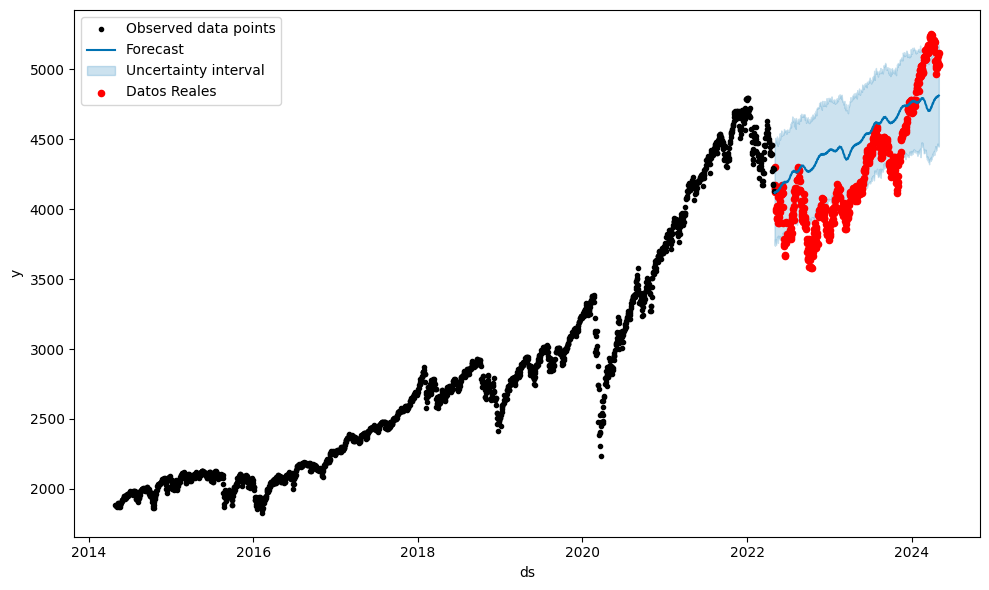

         dia  indice_real  indice_proyectado
0 2022-05-02  4155.379883        4119.067807
1 2022-05-03  4175.479980        4121.085052
2 2022-05-04  4300.169922        4123.386523
3 2022-05-05  4146.870117        4118.305273
4 2022-05-06  4123.339844        4118.539066


In [79]:
# Graficar resultados junto con los datos reales
fig = model.plot(forecast_prophet)
ax = fig.gca()
test_prophet.plot(kind='scatter', x='ds', y='y', color='red', ax=ax, label='Datos Reales')
ax.legend()

plt.show()

# Crear DataFrame con resultados solo para el período de prueba
resultados = pd.DataFrame({
    'dia': forecast_prophet['ds'],
    'indice_real': test_prophet['y'].reset_index(drop=True),
    'indice_proyectado': forecast_prophet['yhat']
})

# Formato del nombre del archivo que incluye variables dinámicas
nombre_archivo = f'resultados_prediccion_prophet{fecha_inicio}_testSize_{test_size_Control}.csv'

# Guardar el DataFrame en un archivo CSV
resultados.to_csv(nombre_archivo, index=True)

# Mostrar los primeros resultados
print(resultados.head())


Agregando variables extenas

In [80]:
# Obtén una lista con todos los nombres de las columnas en el DataFrame
column_names = AllVar_df.columns.tolist()
print("Nombres de columnas en AllVar_df:", column_names)


Nombres de columnas en AllVar_df: ['Open', 'High', 'Low', 'Close', 'Volume', 'DAAA', 'AAA10Y', 'DBAA', 'BAA10Y', 'BAMLH0A0HYM2', 'BAMLH0A2HYB', 'BAMLH0A3HYC', 'BAMLHE00EHYIOAS', 'T10Y2Y', 'T10Y3M', 'T5YIE', 'DEXUSEU', 'DEXCHUS', 'DEXCAUS', 'DEXMXUS', 'VIXCLS', 'GVZCLS', 'Close_oil', '5d_moving_avg', '10d_moving_avg', '20d_moving_avg', '200d_moving_avg', '10d_wma', 'Momentum', 'Stochastic_%K', 'Stochastic_%D', 'RSI_20', 'RSI_10', 'Williams_%R', 'MACD', 'Signal_Line', 'Daily Returns', 'DAAA_daily_change', 'AAA10Y_daily_change', 'DBAA_daily_change', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change', 'BAMLH0A3HYC_daily_change', 'BAMLHE00EHYIOAS_daily_change', 'T10Y2Y_daily_change', 'T10Y3M_daily_change', 'T5YIE_daily_change', 'DEXUSEU_daily_change', 'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change', 'VIXCLS_daily_change', 'GVZCLS_daily_change', 'oil_daily_changes', 'Lag 1_Returns', 'Lag 2_Returns', 'Next_Day_Returns', 'TARGET']


In [81]:
#Seleccionar las columnas que se van a utilizar
selected_columns = ['VIXCLS', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change','T5YIE_daily_change', 'DEXCHUS_daily_change',  'DEXMXUS_daily_change','VIXCLS_daily_change']

# Ahora crea un nuevo DataFrame con solo las columnas seleccionadas
X_Prophet = AllVar_df[selected_columns]
X_Prophet=X_Prophet.loc[fecha_inicio:]

In [82]:
X_Prophet.head()

,VIXCLS,BAA10Y_daily_change,BAMLH0A0HYM2_daily_change,T5YIE_daily_change,DEXCHUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change
Date,,,,,,,
2014-04-30,13.41,0.465116,1.366120,0.512821,0.020774,-0.243986,-2.188184
2014-05-01,13.25,-0.925926,1.078167,0.000000,0.000000,-0.236940,-1.193139
2014-05-02,12.91,0.000000,-0.533333,-0.510204,0.000000,-0.413714,-2.566038
2014-05-05,13.29,0.467290,0.268097,-1.538462,-0.220479,0.073085,2.943455
2014-05-06,13.80,0.000000,-0.534759,-0.520833,-0.317038,-0.042282,3.837472


In [83]:
# Asumiendo que ya tienes un DataFrame llamado 'X_Prophet' con tus variables exógenas y el índice es la columna 'Date'

# Paso 1: Convertir el índice a una columna
X_Prophet.reset_index(inplace=True)

# Paso 2: Renombrar la columna del índice como 'ds'
X_Prophet.rename(columns={'Date': 'ds'}, inplace=True)

# Paso 3: Combinar con tu DataFrame principal (SP500_Prophet)
SP500_Prophet_X = SP500_Prophet.merge(X_Prophet, on='ds', how='left')

# Ahora SP500_Prophet contiene las variables exógenas que puedes utilizar en el modelo Prophet


In [84]:
SP500_Prophet_X.head()

,ds,y,VIXCLS,BAA10Y_daily_change,BAMLH0A0HYM2_daily_change,T5YIE_daily_change,DEXCHUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change
0,2014-04-30,1883.949951,13.41,0.465116,1.366120,0.512821,0.020774,-0.243986,-2.188184
1,2014-05-01,1883.680054,13.25,-0.925926,1.078167,0.000000,0.000000,-0.236940,-1.193139
2,2014-05-02,1881.140015,12.91,0.000000,-0.533333,-0.510204,0.000000,-0.413714,-2.566038
3,2014-05-05,1884.660034,13.29,0.467290,0.268097,-1.538462,-0.220479,0.073085,2.943455
4,2014-05-06,1867.719971,13.80,0.000000,-0.534759,-0.520833,-0.317038,-0.042282,3.837472


In [85]:
# Dividir los datos en conjuntos de entrenamiento y prueba
#cutoff_prophet = int(len(SP500_Prophet_X) * 0.8)
train_prophet_X = SP500_Prophet_X.iloc[:cutoff_prophet]
test_prophet_X = SP500_Prophet_X.iloc[cutoff_prophet:]

In [86]:
# Asumiendo que 'train_prophet' y 'test_prophet' son tus DataFrames que contienen la columna 'ds'

# Obtener el primer y último día del conjunto de entrenamiento
train_start_X = train_prophet_X['ds'].min()
train_end_X = train_prophet_X['ds'].max()

# Obtener el primer y último día del conjunto de prueba
test_start_X = test_prophet_X['ds'].min()
test_end_X = test_prophet_X['ds'].max()

print(f"Train Period: Start - {train_start_X}, End - {train_end_X}")
print(f"Test Period: Start - {test_start_X}, End - {test_end_X}")


Train Period: Start - 2014-04-30 00:00:00, End - 2022-04-29 00:00:00
Test Period: Start - 2022-05-02 00:00:00, End - 2024-04-30 00:00:00


23:21:25 - cmdstanpy - INFO - Chain [1] start processing
23:21:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Test - MSE: 372842.24161653785, RMSE: 610.608091672996, MAE: 573.8381827141214


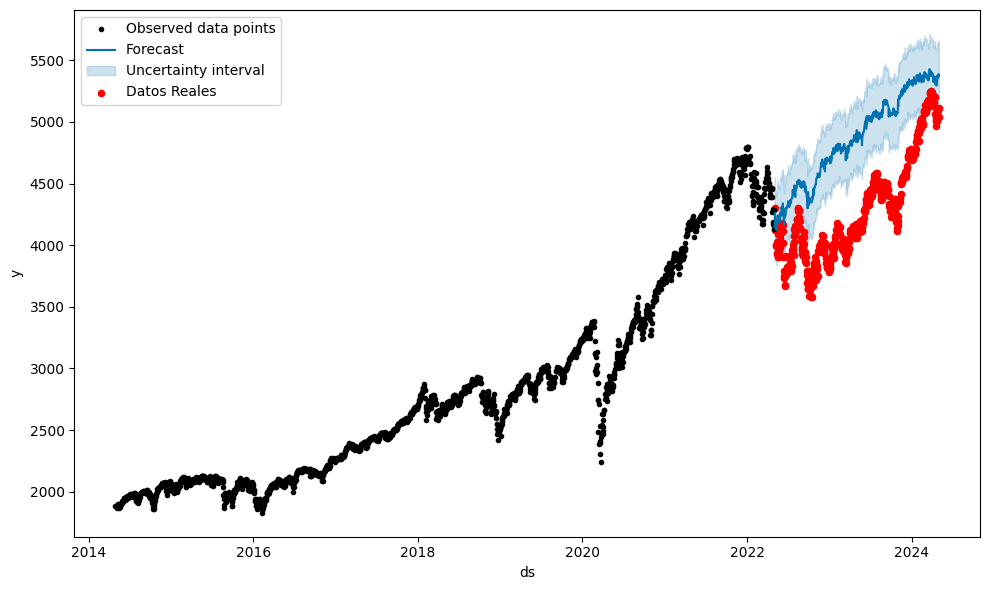

In [87]:
# Ajustar el modelo Prophet
#model_prophet_X = Prophet(daily_seasonality=False)

# Crear una instancia del modelo Prophet con configuraciones específicas
model_prophet_X = Prophet(
    daily_seasonality=False,  # Controlar estacionalidad diaria, desactivada por defecto
    yearly_seasonality=True,  # Habilitar la estacionalidad anual
    weekly_seasonality=True,  # Habilitar la estacionalidad semanal
    seasonality_prior_scale=10,  # Ajustar la flexibilidad de la estacionalidad
    changepoint_prior_scale=0.000575,  # Ajustar la sensibilidad de los puntos de cambio
    n_changepoints=25  # Especificar un número menor de puntos de cambio
)

# Agregar variables exógenas al modelo
for col in SP500_Prophet_X.columns:
    if col != 'ds' and col != 'y':  # No incluir la columna de fechas ni la variable dependiente 'y'
        model_prophet_X.add_regressor(col)

# Ajustar el modelo con los datos de entrenamiento
model_prophet_X.fit(train_prophet_X)

# Realizar predicciones
forecast_prophet_X = model_prophet_X.predict(test_prophet_X)

# Calcular errores de predicción
mse_test = mean_squared_error(test_prophet_X['y'], forecast_prophet_X['yhat'])
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test_prophet_X['y'], forecast_prophet_X['yhat'])
print(f'Test - MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}')

# Graficar resultados junto con los datos reales
fig = model.plot(forecast_prophet_X)
ax = fig.gca()
test_prophet_X.plot(kind='scatter', x='ds', y='y', color='red', ax=ax, label='Datos Reales')
ax.legend()

plt.show()

# Crear DataFrame con resultados solo para el período de prueba
resultados_Prophet_X = pd.DataFrame({
    'dia': forecast_prophet_X['ds'],
    'indice_real': test_prophet_X['y'].reset_index(drop=True),
    'indice_proyectado': forecast_prophet_X['yhat']
})


# Formato del nombre del archivo que incluye variables dinámicas
nombre_archivo_X = f'resultados_prediccion_prophetX{fecha_inicio}_testSize_{test_size_Control}.csv'

# Guardar el DataFrame en un archivo CSV
resultados_Prophet_X.to_csv(nombre_archivo_X, index=True)

In [88]:
print(resultados_Prophet_X )

           dia  indice_real  indice_proyectado
0   2022-05-02  4155.379883        4145.940930
1   2022-05-03  4175.479980        4162.578035
2   2022-05-04  4300.169922        4261.221669
3   2022-05-05  4146.870117        4178.222091
4   2022-05-06  4123.339844        4160.561102
..         ...          ...                ...
492 2024-04-24  5071.629883        5376.575150
493 2024-04-25  5048.419922        5357.066362
494 2024-04-26  5099.959961        5355.409416
495 2024-04-29  5116.169922        5387.677103
496 2024-04-30  5035.689941        5373.276950

[497 rows x 3 columns]


PROPHET CADA DIA

Prophet incorporando valores reales diarios conforme van ocurriendo

23:22:59 - cmdstanpy - INFO - Chain [1] start processing
23:22:59 - cmdstanpy - INFO - Chain [1] done processing
23:22:59 - cmdstanpy - INFO - Chain [1] start processing
23:22:59 - cmdstanpy - INFO - Chain [1] done processing
23:22:59 - cmdstanpy - INFO - Chain [1] start processing
23:22:59 - cmdstanpy - INFO - Chain [1] done processing
23:22:59 - cmdstanpy - INFO - Chain [1] start processing
23:23:00 - cmdstanpy - INFO - Chain [1] done processing
23:23:00 - cmdstanpy - INFO - Chain [1] start processing
23:23:00 - cmdstanpy - INFO - Chain [1] done processing
23:23:00 - cmdstanpy - INFO - Chain [1] start processing
23:23:00 - cmdstanpy - INFO - Chain [1] done processing
23:23:00 - cmdstanpy - INFO - Chain [1] start processing
23:23:00 - cmdstanpy - INFO - Chain [1] done processing
23:23:00 - cmdstanpy - INFO - Chain [1] start processing
23:23:00 - cmdstanpy - INFO - Chain [1] done processing
23:23:01 - cmdstanpy - INFO - Chain [1] start processing
23:23:01 - cmdstanpy - INFO - Chain [1]

Test - MSE: 98948.45260957789, RMSE: 314.5607296049173, MAE: 258.4203974084521


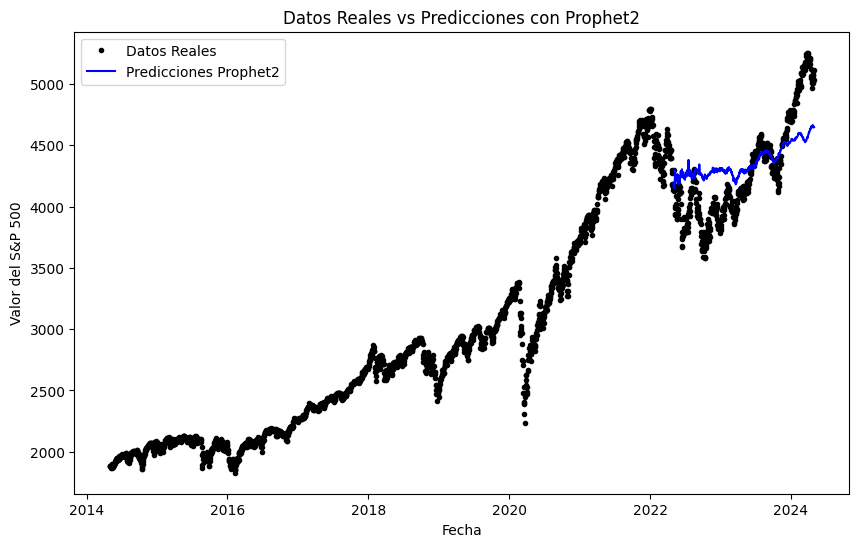

In [89]:
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

# División en conjuntos de entrenamiento y prueba
train_size_prophet2 = int(len(SP500_Prophet) * (1-test_size_Control))
train_prophet2 = SP500_Prophet.iloc[:train_size_prophet2].copy()
test_prophet2 = SP500_Prophet.iloc[train_size_prophet2:].copy()

predictions_prophet2 = []
dates_for_plot_prophet2 = []

for index, row in test_prophet2.iterrows():
    # Crear un DataFrame para la próxima fecha
    future_prophet2 = pd.DataFrame([row['ds']], columns=['ds'])
    
    # Instanciar un nuevo modelo Prophet para cada iteración
    #model_prophet2 = Prophet(daily_seasonality=False)
    # Crear una nueva instancia del modelo Prophet con configuraciones específicas para 'model_prophet2'
    model_prophet2 = Prophet(
    daily_seasonality=False,  # Desactivar la estacionalidad diaria si tus datos no tienen variación diaria significativa
    yearly_seasonality=True,  # Habilitar la estacionalidad anual si tus datos muestran variación a lo largo del año
    weekly_seasonality=True,  # Habilitar la estacionalidad semanal para capturar patrones semanales
    seasonality_prior_scale=20,  # Ajustar la flexibilidad de la estacionalidad para permitir mayor adaptabilidad
    changepoint_prior_scale=0.00075,  # Reducir la sensibilidad de los puntos de cambio para evitar sobreajustes
    n_changepoints=10  # Reducir el número de puntos de cambio automáticos para un modelo más estable
    )
    
    model_prophet2.fit(train_prophet2[['ds', 'y']])
    
    # Realizar predicción para la próxima fecha
    forecast_prophet2 = model_prophet2.predict(future_prophet2)
    
    # Guardar la predicción
    predictions_prophet2.append(forecast_prophet2['yhat'].iloc[0])
    dates_for_plot_prophet2.append(row['ds'])
    
    # Agregar la observación real al DataFrame de entrenamiento para el próximo reentrenamiento
    train_prophet2 = pd.concat([train_prophet2, pd.DataFrame([row]).reset_index(drop=True)], ignore_index=True)

# Añadir predicciones al DataFrame de test para comparación
test_prophet2['predictions'] = predictions_prophet2

# Cálculo de métricas de error basadas en las predicciones actualizadas
mse_test_prophet2 = mean_squared_error(test_prophet2['y'], test_prophet2['predictions'])
rmse_test_prophet2 = np.sqrt(mse_test_prophet2)
mae_test_prophet2 = mean_absolute_error(test_prophet2['y'], test_prophet2['predictions'])

print(f'Test - MSE: {mse_test_prophet2}, RMSE: {rmse_test_prophet2}, MAE: {mae_test_prophet2}')

# Graficar los datos reales de todo el período y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(SP500_Prophet['ds'], SP500_Prophet['y'], 'k.', label='Datos Reales')
plt.plot(dates_for_plot_prophet2, predictions_prophet2, 'b-', label='Predicciones Prophet2')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Valor del S&P 500')
plt.title('Datos Reales vs Predicciones con Prophet2')
plt.show()


# Formato del nombre del archivo que incluye variables dinámicas
nombre_archivo_prophet2 = f'resultados_prediccion_prophe_daily{fecha_inicio}_testSize_{test_size_Control}.csv'

# Guardar el DataFrame en un archivo CSV
test_prophet2.to_csv(nombre_archivo, index=True)

In [90]:
# Mostrar los primeros resultados
print(test_prophet2.head())

             ds            y  predictions
1984 2022-05-02  4155.379883  4194.121517
1985 2022-05-03  4175.479980  4156.568858
1986 2022-05-04  4300.169922  4149.162943
1987 2022-05-05  4146.870117  4165.100758
1988 2022-05-06  4123.339844  4196.665251
